- $\textbf{Author}$: Patrick L. Mthisi
- $\textbf{Contact details}$: patrickmthisi@hotmail.com

# Telco Customer Churn Prediction:

The dataset used in the project was sourced from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data.

About Dataset:

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

# Objectives:

The project aims to analyze relevant customer data and develop a targeted customer retention program to predict customer behavior. The study addressed the following aspects:
- Exploring a vast number of machine learning models to predict customer churn.
- Creating a production-ready scorecard that ranks Telco customers in terms of the probability of churn or attrition.
- The feature engineering techniques employed entail binning all variables and selecting the most predictive variables based on their IV and Gini coefficients.
- A weight of evidence (WoE) feature transformation is applied to the selected variables before being incorporated into the customer churn scorecard.
- Customers are grouped into deciles based on the probability of churn.
- The stability of the scorecard is assessed using the PSI and CSI measured on the evaluation dataset, which proxies the evolved data.

In [1]:
# matplotlib configuration
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from ydata_profiling import ProfileReport
import missingno as msno 

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import lazypredict
from lazypredict.supervised import LazyClassifier

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
from optbinning.scorecard import ScorecardMonitoring

import sweetviz

import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/pmthisi/code_env/00_Projects_end_to_end/4_Telco_Customer_Churn'

# Data extraction:

In [4]:
# load dataset 
class Classification_Data_Extractor(object):
    # constructor
    def __init__(self, filename, verbose=True):
        self.filename = filename
        self.verbose = verbose
    
    # load dataset and remove duplicates
    def load_dataset_dedup(self):
        self.dataset = pd.read_csv(self.filename)
        initial_shape = self.dataset.shape
        self.dataset.drop_duplicates(inplace=True)
        final_shape = self.dataset.shape
        if self.verbose:
            print(f"Loaded dataset with shape: {initial_shape}")
            print(f"Dataset shape after removing duplicates: {final_shape}")
            
    # reduce memory usage
    def reduce_mem_usage(self):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = self.dataset.memory_usage().sum() / 1024**2    
        for col in self.dataset.columns:
            col_type = self.dataset[col].dtypes
            if col_type in numerics:
                c_min = self.dataset[col].min()
                c_max = self.dataset[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        self.dataset[col] = self.dataset[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        self.dataset[col] = self.dataset[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        self.dataset[col] = self.dataset[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        self.dataset[col] = self.dataset[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        self.dataset[col] = self.dataset[col].astype(np.float32)
                    else:
                        self.dataset[col] = self.dataset[col].astype(np.float64)    
        end_mem = self.dataset.memory_usage().sum() / 1024**2
        if self.verbose: 
            print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
            
    # get the dataset
    def get_dataset(self):
        return self.dataset
    
# summarise value counts and percentage of examples in each class
def summarise_target(y):
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    # summarise the value counts for each class label
    counter = Counter(y)
    # summarise class distribution
    for k, v in counter.items():
        per = v / len(y) * 100
        print(f'Class={k}, Count={v}, Percentage={per:.3f}%')
    
def disp_side_by_side(*dataframes):
        html = '<div style="display:flex">'
        non_empty_dfs = [df for df in dataframes if not df.empty]
        if len(non_empty_dfs) == 1:
            dataframe = non_empty_dfs[0]
            html += '<div style="margin-right: 2em">'
            html += dataframe.to_html()
            html += '</div>'
        elif len(non_empty_dfs) > 1:
            for dataframe in non_empty_dfs:
                html += '<div style="margin-right: 2em">'
                html += dataframe.to_html()
                html += '</div>'
        html += '</div>'
        display(HTML(html))
    
# display univariate summary statistics
def summary_stats_analyzer(dataset):
    try:
        df1 = dataset.describe(include=['object', 'bool'])
    except ValueError:
        df1 = pd.DataFrame({'Note': ['No object or bool columns present']})
    df2 = dataset.describe()
    return disp_side_by_side(df1, df2)   


# perform train, validation and test split: https://www.analyticsvidhya.com/blog/2023/11/train-test-validation-split/
def stratified_train_val_test_split(X, y, frac_train=0.7, frac_val=0.2, frac_test=0.1, random_state=None, verbose=True):
    if not np.isclose(frac_train + frac_val + frac_test, 1.0):
        raise ValueError(f'{frac_train:.2f}, {frac_val:.2f}, and {frac_test:.2f} do not add up to 1.0')
        
    # split into train and temp dataset
    X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                        y, 
                                                        test_size=(1 - frac_train),
                                                        random_state=random_state, 
                                                        stratify=y)
    # split temp datasets into val and test dataset
    relative_frac_test = frac_test / (frac_test + frac_val)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                    y_temp, 
                                                    test_size=relative_frac_test, 
                                                    random_state=random_state, 
                                                    stratify=y_temp)
    
    assert len(X) == len(X_train) + len(X_val) + len(X_test)
    
    # Check the class distribution
    if verbose:
        print("Class distribution in training set:") 
        print(summarise_target(y_train))
        print("\nClass distribution in validation set:")
        print(summarise_target(y_val))
        print("\nClass distribution in test set:")
        print(summarise_target(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
filename = "Telco_Customer_Churn.csv"
target = "Churn"
ID = "customerID"
extractor = Classification_Data_Extractor(filename)
extractor.load_dataset_dedup()
extractor.reduce_mem_usage()

Loaded dataset with shape: (7043, 21)
Dataset shape after removing duplicates: (7043, 21)
Mem. usage decreased to  1.01 Mb (10.7% reduction)


# Explanatory data analysis:

In [6]:
dataset = extractor.get_dataset()
dataset.drop(columns=[ID], axis=1, inplace=True)
summary_stats_analyzer(dataset)

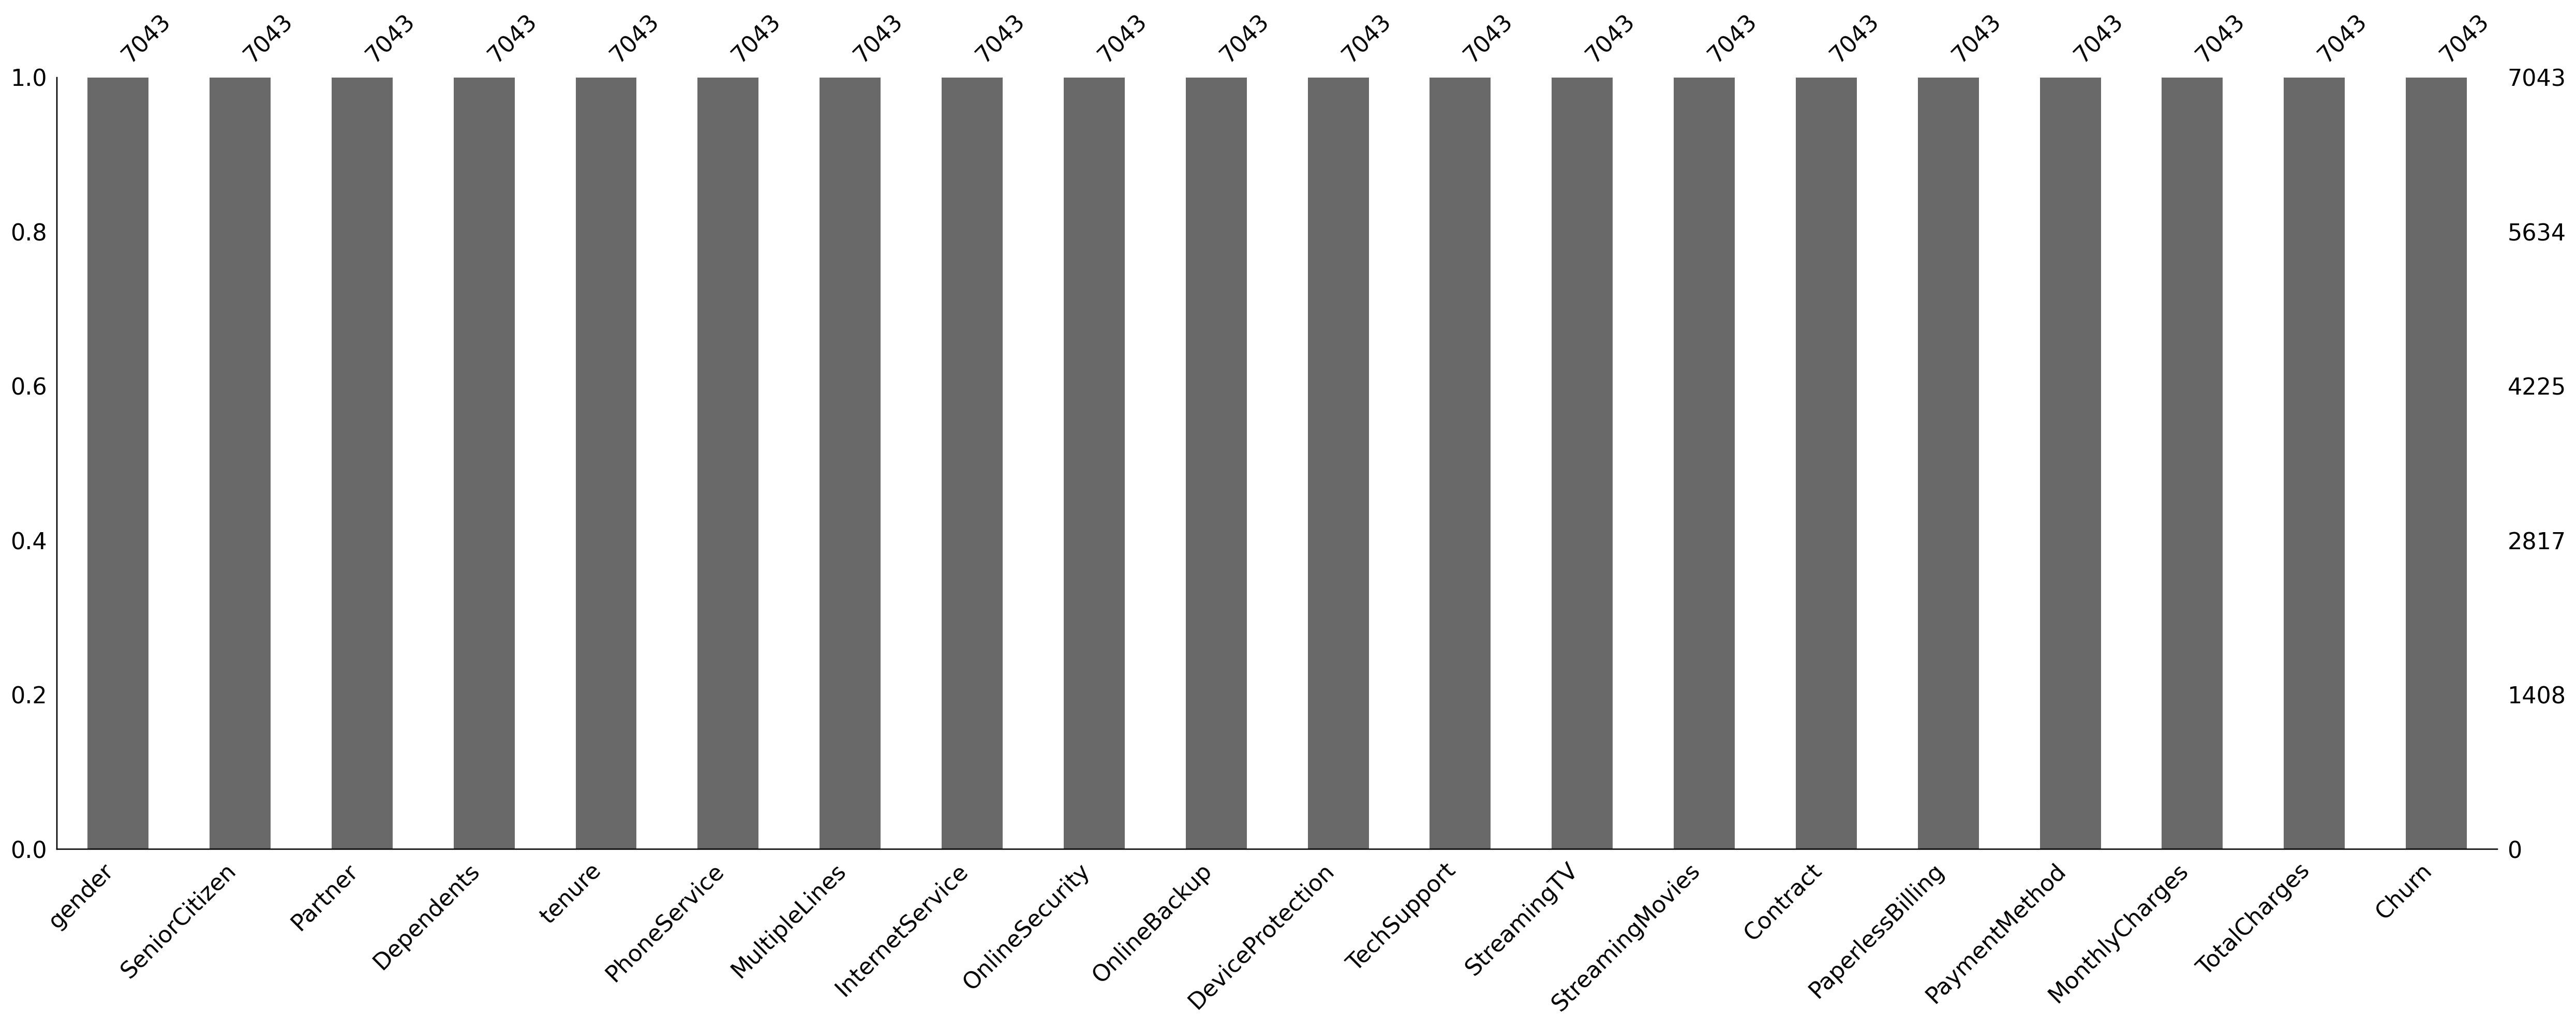

In [7]:
msno.bar(dataset)

sns.despine()
plt.tight_layout()

In [8]:
os.makedirs('Telco_Churn_EDA', exist_ok=True)
Telco_churn_full_report = sweetviz.analyze(dataset)
Telco_churn_full_report.show_html('Telco_Churn_EDA/Telco_churn_full_report.html')

                                             |                                                                …

Report Telco_Churn_EDA/Telco_churn_full_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Prepare data for modelling:

## Split data into training, validation, and test dataset

In [9]:
seed = 1710

In [10]:
variable_names = list(dataset.columns.difference([target]))
categorical_variables = list(dataset.select_dtypes(include=['object', 'bool']))

X = dataset[variable_names]
y = dataset[target].values

mask = y == 'Yes'
y[mask] = 1
y[~mask] = 0
y = y.astype(int)
# summarise data
summarise_target(y)

Class=0, Count=5174, Percentage=73.463%
Class=1, Count=1869, Percentage=26.537%


In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = stratified_train_val_test_split(X, y, random_state=seed, verbose=True)

Class distribution in training set:
Class=0, Count=3622, Percentage=73.469%
Class=1, Count=1308, Percentage=26.531%
None

Class distribution in validation set:
Class=0, Count=1034, Percentage=73.438%
Class=1, Count=374, Percentage=26.562%
None

Class distribution in test set:
Class=0, Count=518, Percentage=73.475%
Class=1, Count=187, Percentage=26.525%
None


Library libsecret-1.so.0 cannot be loaded, related functionality will not be available

(tilix:2224): GLib-GObject-WARNING **: 14:48:19.687: invalid (NULL) pointer instance

(tilix:2224): GLib-GObject-CRITICAL **: 14:48:19.687: g_signal_handlers_disconnect_matched: assertion 'G_TYPE_CHECK_INSTANCE (instance)' failed


## Visualize variable distributions

In [12]:
train_val_report = sweetviz.compare(X_train, X_val)
train_val_report.show_html('Telco_Churn_EDA/train_val_report.html')

                                             |                                                                …

Report Telco_Churn_EDA/train_val_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [13]:
train_test_report = sweetviz.compare(X_train, X_test)
train_test_report.show_html('Telco_Churn_EDA/train_test_report.html')

                                             |                                                                …

Library libsecret-1.so.0 cannot be loaded, related functionality will not be available

(tilix:2369): GLib-GObject-WARNING **: 14:48:33.189: invalid (NULL) pointer instance

(tilix:2369): GLib-GObject-CRITICAL **: 14:48:33.190: g_signal_handlers_disconnect_matched: assertion 'G_TYPE_CHECK_INSTANCE (instance)' failed


Report Telco_Churn_EDA/train_test_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Library libsecret-1.so.0 cannot be loaded, related functionality will not be available

(tilix:2514): GLib-GObject-WARNING **: 14:48:38.438: invalid (NULL) pointer instance

(tilix:2514): GLib-GObject-CRITICAL **: 14:48:38.438: g_signal_handlers_disconnect_matched: assertion 'G_TYPE_CHECK_INSTANCE (instance)' failed


## Variable transformation and selection

In [14]:
selection_criteria = {
    "iv": {"min": 0.025, "max": 1},
    "gini": {"min": 0.20}
}

# Instantiate binning process
binning_process = BinningProcess(variable_names=variable_names, 
                                 categorical_variables=categorical_variables,
                                 selection_criteria=selection_criteria
                                )


binning_process.fit(X_train, y_train)

BinningProcess(categorical_variables=['gender', 'Partner', 'Dependents',
                                      'PhoneService', 'MultipleLines',
                                      'InternetService', 'OnlineSecurity',
                                      'OnlineBackup', 'DeviceProtection',
                                      'TechSupport', 'StreamingTV',
                                      'StreamingMovies', 'Contract',
                                      'PaperlessBilling', 'PaymentMethod',
                                      'TotalCharges', 'Churn'],
               selection_criteria={'gini': {'min': 0.2},
                                   'iv': {'max': 1, 'min': 0.025}},
               variable_names=['Contract', 'Dependents', 'DeviceProtection',
                               'InternetService', 'MonthlyCharges',
                               'MultipleLines', 'OnlineBackup',
                               'OnlineSecurity', 'PaperlessBilling', 'Partner',
                               'PaymentMethod', 'PhoneService', 'SeniorCitizen',
                               'StreamingMovies', 'StreamingTV', 'TechSupport',
                               'TotalCharges', 'gender', 'tenure'])

In [15]:
binning_process.information(print_level=2)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    selection_criteria                   yes   * U
    fixed_variables                       no   * d
    categorical_variables                yes   * U
    special_codes                         no   * d
    split_digits                          no   * d
    binning_fit_params                    no   * d
    binning_transform_params              no   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                   49

# Model development:

## Get best model:

In [16]:
# transform data
X_train_woe, X_test_woe = binning_process.transform(X_train).values, binning_process.transform(X_test).values

# define models
estimator = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=seed, classifiers='all')
# Fit the pipeline on the training data
models, predictions = estimator.fit(X_train_woe, X_test_woe, y_train, y_test)
predictions

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.88it/s]

[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265314 -> initscore=-1.018527
[LightGBM] [Info] Start training from score -1.018527


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.77,0.76,0.76,0.78,0.01
BernoulliNB,0.76,0.76,0.76,0.77,0.01
XGBClassifier,0.80,0.74,0.74,0.80,0.65
NearestCentroid,0.67,0.74,0.74,0.69,0.04
LGBMClassifier,0.81,0.74,0.74,0.80,0.06
LinearDiscriminantAnalysis,0.81,0.73,0.73,0.80,0.02
AdaBoostClassifier,0.82,0.73,0.73,0.81,0.14
LinearSVC,0.81,0.73,0.73,0.81,0.11
CalibratedClassifierCV,0.81,0.73,0.73,0.80,0.07


## Build a scorecard:

In [17]:
# select logistic regression, but any other top model can be used as shown in the analysis above:
# grid search best parameters before implementing into a scorecard
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# define pipeline
steps = []
steps.append(('binning_process', binning_process))
steps.append(('clf', LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=seed)))
estimator = Pipeline(steps=steps)
# define grid
param_grid = {}
param_grid['clf__solver'] = ['liblinear', 'lbfgs']
param_grid['clf__C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
param_grid['clf__max_iter'] = [100, 500, 1000, 5000]

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
# define grid search 
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)
# summarise best parameters
print('Best %f using %s' % (grid_result.best_score_, grid_result.best_params_ ))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best 0.828323 using {'clf__C': 0.1, 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 100, 'clf__solver': 'lbfgs'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 500, 'clf__solver': 'liblinear'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 500, 'clf__solver': 'lbfgs'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 1000, 'clf__solver': 'liblinear'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 1000, 'clf__solver': 'lbfgs'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 5000, 'clf__solver': 'liblinear'}
0.811445 (0.019573) with: {'clf__C': 1e-06, 'clf__max_iter': 5000, 'clf__solver': 'lbfgs'}
0.811536 (0.019549) with: {'clf__C': 1e-05, 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
0.811533 (0.019550) with: {'clf__C': 1e-05, 'clf__max_iter': 100, 'clf__solver':

In [18]:
best_params = grid_result.best_params_
best_params_df = pd.DataFrame([best_params])
best_params_df.to_csv('Telco_Churn_EDA/best_params.csv', index=False)

In [19]:
# Extract each parameter
C = best_params_df['clf__C'].iloc[0]
max_iter = best_params_df['clf__max_iter'].iloc[0]
solver = best_params_df['clf__solver'].iloc[0]

In [20]:
estimator = LogisticRegression(solver=solver, class_weight='balanced', C=C, max_iter=max_iter)

# instantiate scorecard object
scorecard = Scorecard(binning_process=binning_process, 
                      estimator=estimator, 
                      scaling_method="min_max", 
                      scaling_method_params={"min": 0 , "max":100})

# fit scorecard
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['gender',
                                                                'Partner',
                                                                'Dependents',
                                                                'PhoneService',
                                                                'MultipleLines',
                                                                'InternetService',
                                                                'OnlineSecurity',
                                                                'OnlineBackup',
                                                                'DeviceProtection',
                                                                'TechSupport',
                                                                'StreamingTV',
                                                                'StreamingMovies',
                                                                'Contract',
                                                                'PaperlessBilling',
                                                                'PaymentMethod',
                                                                'TotalCharges',
                                                                'Churn'],
                                         selection_criteria={'gini': {'min': 0.2}...
                                                         'MultipleLines',
                                                         'OnlineBackup',
                                                         'OnlineSecurity',
                                                         'PaperlessBilling',
                                                         'Partner',
                                                         'PaymentMethod',
                                                         'PhoneService',
                                                         'SeniorCitizen',
                                                         'StreamingMovies',
                                                         'StreamingTV',
                                                         'TechSupport',
                                                         'TotalCharges',
                                                         'gender', 'tenure']),
          estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                       solver='liblinear'),
          scaling_method='min_max',
          scaling_method_params={'max': 100, 'min': 0})

In [21]:
# get run time information 
scorecard.information(print_level=1)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                   4930
    Number of variables                   19
    Target type                       binary

    Number of numerical                    3
    Number of categorical                 16
    Number of selected                    11

  Timing
    Total time                          0.52 sec
    Binning process                     0.49 sec   ( 93.67%)
    Estimator                           0.01 sec   (  1.29%)
    Build scorecard                     0.03 sec   (  4.86%)
      rounding                          0.00 sec   (  0.00%)



## Evaluate scorecard Performance:

In this analysis we will analyse model performance on the validation dataset. The test dataset is reversed for the purpose of monitoring. 

In [22]:
# get predictions and calculate evaluation metrics
y_test_probs = scorecard.predict_proba(X_test)[:, 1]

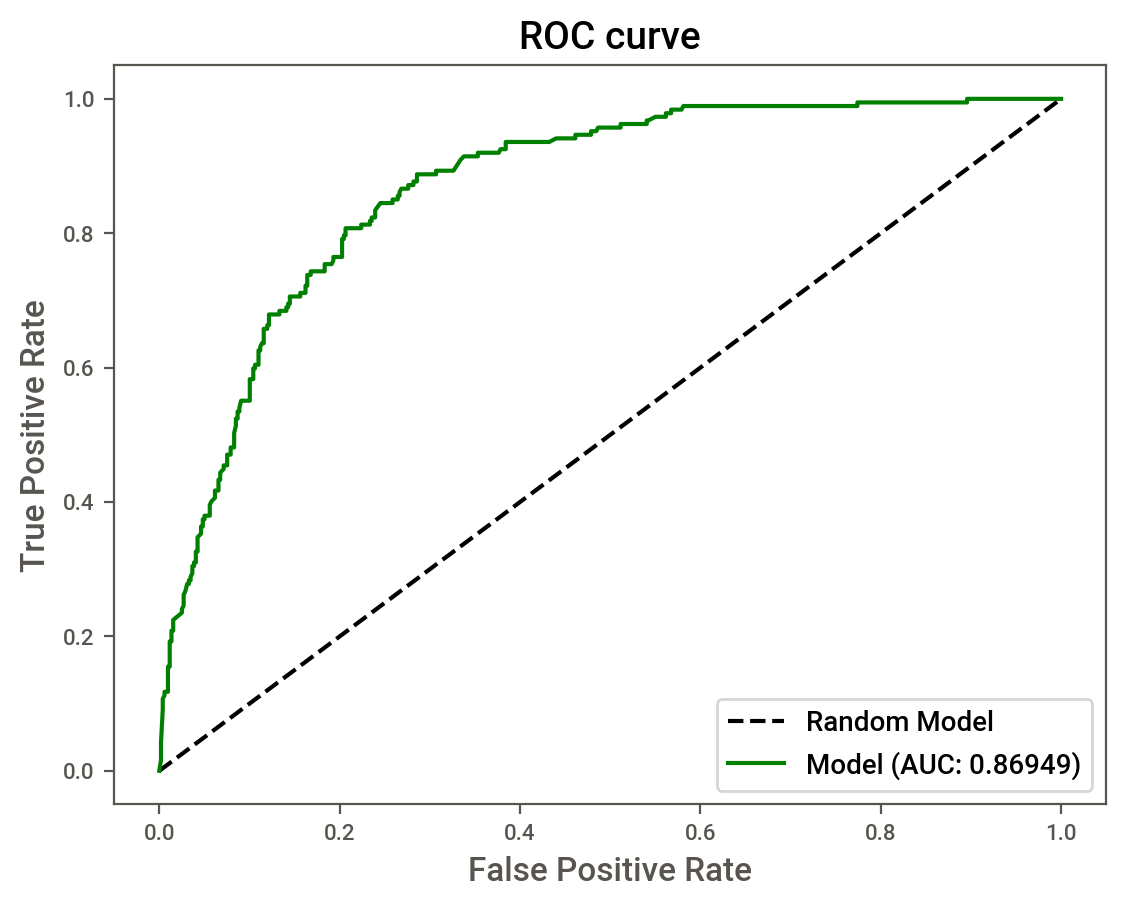

In [23]:
# calculate ROC AUC
plot_auc_roc(y_test, y_test_probs)

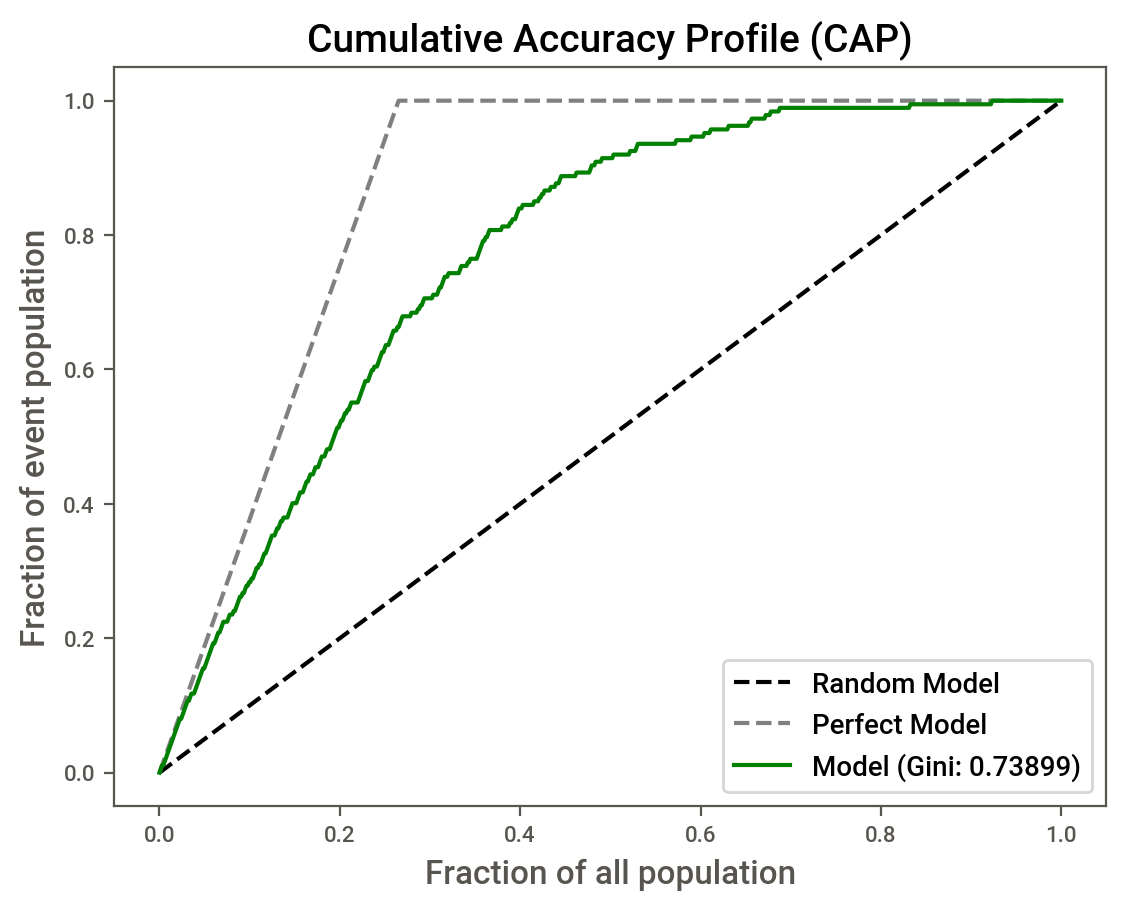

In [24]:
# calculate Gini
plot_cap(y_test, y_test_probs)

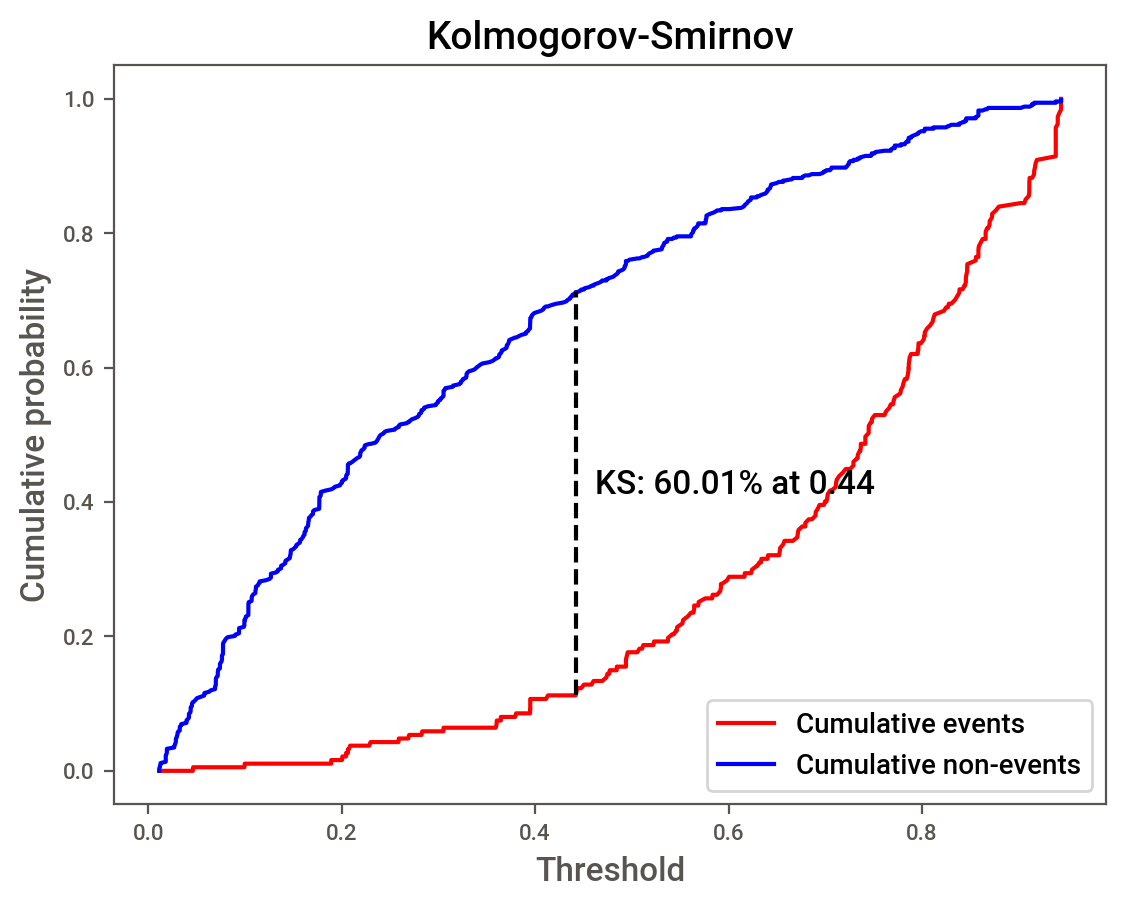

In [25]:
# Generate the KS plot
plot_ks(y_test, y_test_probs)

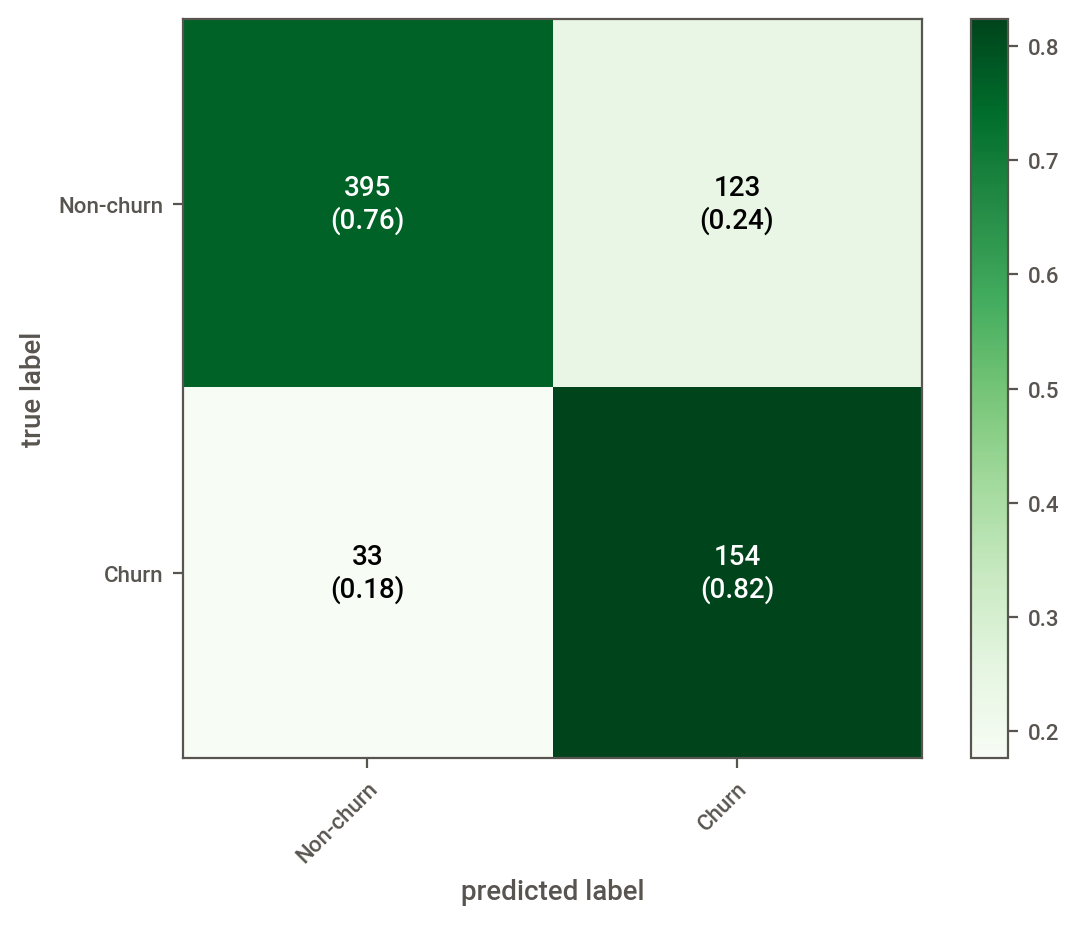

In [26]:
# https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/
y_test_pred = scorecard.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(conf_mat=cm, 
                      show_absolute=True, 
                      show_normed=True, 
                      colorbar=True, 
                      class_names = ['Non-churn', 'Churn'], 
                      cmap='Greens')
# show plot
plt.show()

In [27]:
# Write scorecard to file
os.makedirs('customer_churn', exist_ok=True)
path = 'customer_churn/'
scorecard_name = 'customer_churn_scorecard.pkl'
Scorecard.save(path=f'{path}{scorecard_name}', self=scorecard)

## Perform scorecard monitoring on 'evolved' data:

We now evaluate the model's performance on evolved data, which in this case is assumed to be the out-of-sample validation data.

In [28]:
# load scorecard
scorecard = Scorecard.load(path=f'{path}{scorecard_name}')

In [29]:
# instantiate the ScorecardMonitoring object class
monitoring = ScorecardMonitoring(scorecard=scorecard, psi_method="cart", psi_n_bins=10, verbose=True)
monitoring.fit(X_val, y_val, X_train, y_train)

2025-07-03 14:53:52,191 | INFO : Monitoring started.
2025-07-03 14:53:52,193 | INFO : Options: check parameters.
2025-07-03 14:53:52,194 | INFO : System stability analysis started.
2025-07-03 14:53:52,289 | INFO : System stability analysis terminated. Time: 0.0940s
2025-07-03 14:53:52,290 | INFO : Variable analysis started.
2025-07-03 14:53:52,332 | INFO : Variable analysis terminated. Time: 0.0413s
2025-07-03 14:53:52,333 | INFO : Monitoring terminated. Time: 0.1420s


ScorecardMonitoring(psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(categorical_variables=['gender',
                                                                                              'Partner',
                                                                                              'Dependents',
                                                                                              'PhoneService',
                                                                                              'MultipleLines',
                                                                                              'InternetService',
                                                                                              'OnlineSecurity',
                                                                                              'OnlineBackup',
                                                                                              'DeviceProtection',
                                                                                              'TechSupport',
                                                                                              'StreamingTV',
                                                                                              'StreamingMovies',
                                                                                              'Contract',
                                                                                              'PaperlessBilling',
                                                                                              'PaymentMethod',
                                                                                              'TotalCharges',
                                                                                              'Ch...
                                                                                       'MultipleLines',
                                                                                       'OnlineBackup',
                                                                                       'OnlineSecurity',
                                                                                       'PaperlessBilling',
                                                                                       'Partner',
                                                                                       'PaymentMethod',
                                                                                       'PhoneService',
                                                                                       'SeniorCitizen',
                                                                                       'StreamingMovies',
                                                                                       'StreamingTV',
                                                                                       'TechSupport',
                                                                                       'TotalCharges',
                                                                                       'gender',
                                                                                       'tenure']),
                                        estimator=LogisticRegression(C=0.1,
                                                                     class_weight='balanced',
                                                                     solver='liblinear'),
                                        scaling_method='min_max',
                                        scaling_method_params={'max': 100,
                                                               'min': 0}),
                    verbose=True)

In [30]:
monitoring.information(print_level=1)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records Actual            1408
    Number of records Expected          4930
    Number of scorecard variables         11
    Target type                       binary

  Timing
    Total time                          0.14 sec
    System stability                    0.09 sec   ( 66.20%)
    Variables stability                 0.04 sec   ( 29.05%)



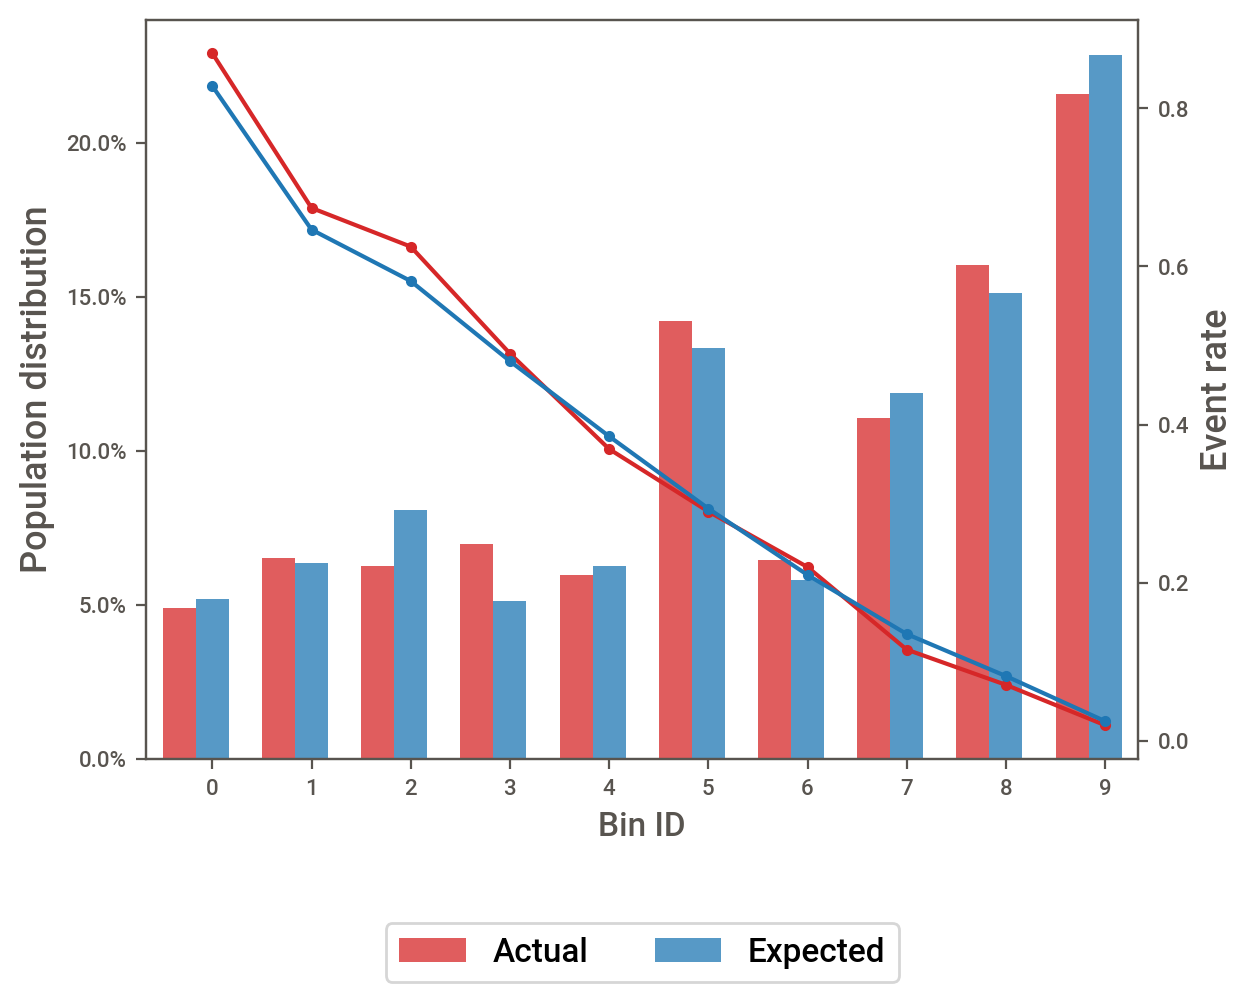

In [31]:
# analyse the population decile distribution 
monitoring.psi_plot()

In [32]:
# Compute Chi-square test to test the null hypothesis: actual = expected.
print(monitoring.tests_table())

              Bin  Count A  Count E  Event rate A  Event rate E  statistic  \
0   (-inf, 20.54)       69      256          0.87          0.83       0.68   
1  [20.54, 25.64)       92      314          0.67          0.65       0.24   
2  [25.64, 30.25)       88      399          0.62          0.58       0.56   
3  [30.25, 33.29)       98      252          0.49          0.48       0.03   
4  [33.29, 36.50)       84      309          0.37          0.39       0.07   
5  [36.50, 43.19)      200      657          0.29          0.29       0.01   
6  [43.19, 45.44)       91      286          0.22          0.21       0.04   
7  [45.44, 51.68)      156      585          0.12          0.14       0.42   
8  [51.68, 59.34)      226      745          0.07          0.08       0.29   
9    [59.34, inf)      304     1127          0.02          0.02       0.27   

   p-value  
0     0.41  
1     0.63  
2     0.45  
3     0.87  
4     0.79  
5     0.92  
6     0.84  
7     0.52  
8     0.59  
9     0.60 

In [33]:
# generate stability report
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0139 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10       1.00
    [0.10, 0.25)      0       0.00
    [0.25, Inf+)      0       0.00

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0       0.00
    [0.05, 0.10)      0       0.00
    [0.10, 0.50)      2       0.20
    [0.50, 1.00)      8       0.80

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records    1408          -      4930            -
        Event records     374       0.27      1308         0.27
    Non-event records    1034       0.73      3622         0.73

  Performance metrics

                 Metric  Actual  Expected  Diff A - E
     True positive rate    0.79      0.77        0.02
     True negative rate    0.75

In [34]:
# calculate characteristic stability index (CSI) for each variable
print(monitoring.psi_variable_table(style="summary"))

            Variable  PSI
0   DeviceProtection 0.00
1    InternetService 0.00
2     MonthlyCharges 0.01
3       OnlineBackup 0.00
4     OnlineSecurity 0.01
5   PaperlessBilling 0.00
6      PaymentMethod 0.00
7    StreamingMovies 0.00
8        StreamingTV 0.00
9        TechSupport 0.00
10            tenure 0.00


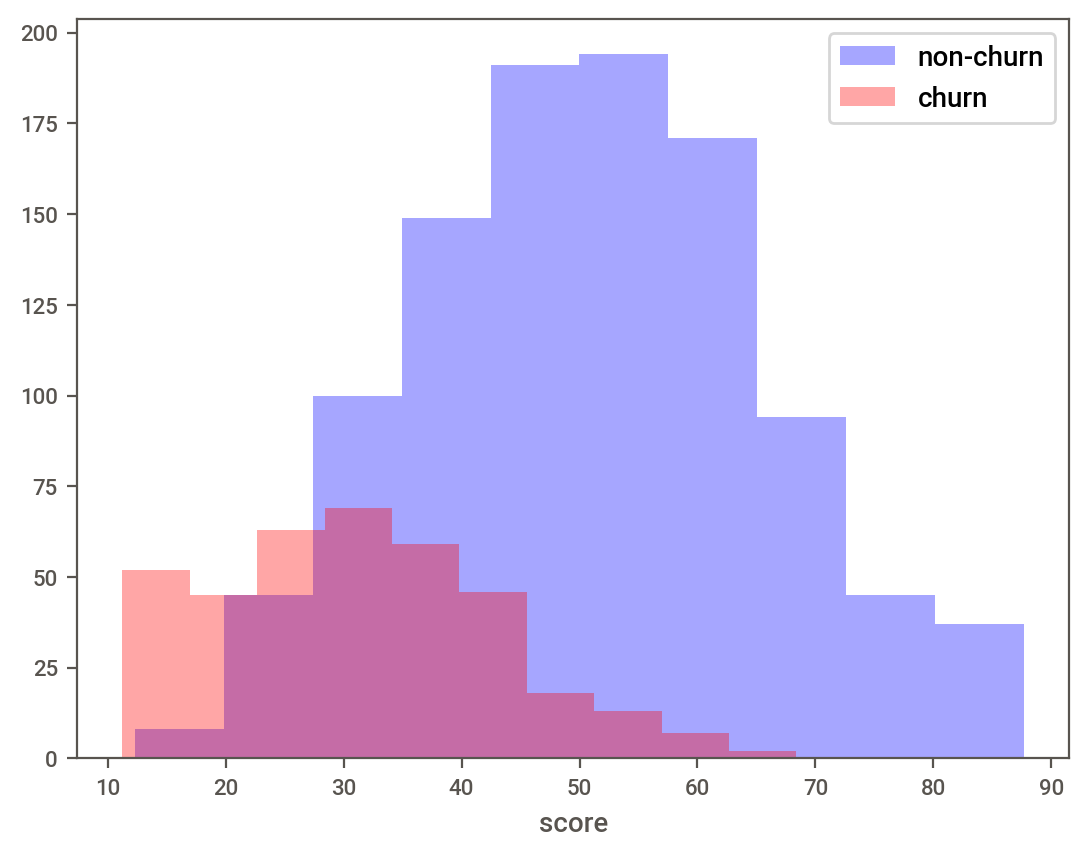

In [35]:
# score unseen test dataset and analyze the distribution of scores
score = scorecard.score(X_val)
mask = y_val == 0
plt.hist(score[mask], label='non-churn', color='b', alpha=0.35)
plt.hist(score[~mask], label='churn', color='r', alpha=0.35)
plt.xlabel('score')
plt.legend()
# show plot
plt.show()

# Conclusion and further work...

In this project, we created a customer attrition scorecard that can be used to evaluate clients based on their likelihood of attrition. The scorecard shows stellar performance, achieving a ROC AUC of 87% (and Gini of 0.74), which is quite comparable, if not better, than most models that were presented on Kaggle by other participants:

The performance of the scorecard was evaluated using out-of-sample "evolved" data. The scorecard effectively ranked risk, as demonstrated by the decile distribution and the churn versus non-churn distribution shown below:

Other models can be explored in this project, as well as other variable selection criteria.